<a href="https://colab.research.google.com/github/runtorain/GenerativeDeepLearning/blob/main/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [2]:
# Constants
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0005

In [3]:
# Data Preprocessing (Normalization, Augmentation, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])

In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [6]:
# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers with BatchNorm and LeakyReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [7]:
# Instantiate the model
model = SimpleCNN()

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 2.0696, Accuracy: 38.56%
Epoch [2/10], Loss: 1.9485, Accuracy: 50.85%
Epoch [3/10], Loss: 1.8989, Accuracy: 55.97%
Epoch [4/10], Loss: 1.8635, Accuracy: 59.60%
Epoch [5/10], Loss: 1.8351, Accuracy: 62.43%
Epoch [6/10], Loss: 1.8114, Accuracy: 64.86%
Epoch [7/10], Loss: 1.7967, Accuracy: 66.25%
Epoch [8/10], Loss: 1.7784, Accuracy: 68.21%
Epoch [9/10], Loss: 1.7686, Accuracy: 69.16%
Epoch [10/10], Loss: 1.7574, Accuracy: 70.26%


In [11]:
# Evaluation Loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 71.09%


In [12]:
from torchsummary import summary

# Provide the input shape (excluding batch size)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 16, 16]           9,248
       BatchNorm2d-4           [-1, 32, 16, 16]              64
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Linear-9                  [-1, 128]         524,416
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 591,658
Trainable params: 591,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [13]:
# Save the model's state dictionary
torch.save(model.state_dict(), "cnn.pth")

In [14]:
# Define the model architecture
loaded_model = SimpleCNN()

# Load the state dictionary
loaded_state_dict = torch.load("cnn.pth", weights_only=True)
loaded_model.load_state_dict(loaded_state_dict)

# Put the model in evaluation mode
loaded_model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
# Evaluation Loop
loaded_model.eval()  # Set loaded_model to evaluation mode
loaded_model.to(device)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 71.09%


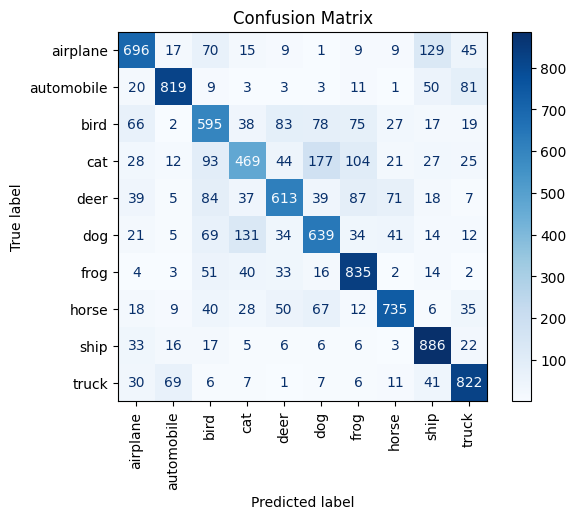

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASSES = np.array([
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
])

# Put the model in evaluation mode
model.eval()

# Convert test data to a DataLoader
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize arrays to store true labels and predictions
true_labels = []
pred_labels = []

# Loop through test data
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move data to the same device as the model
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Get predictions
        logits = model(x_batch)
        preds = torch.argmax(logits, dim=1)  # Get predicted class indices

        # Append true and predicted labels
        true_labels.extend(y_batch.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=CLASSES)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()